In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import Compose

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transform = Compose(
    [Resize((224, 224)),
    ToTensor()]
)

In [ ]:
train_data = FashionMNIST(root = './data', train = True,
                          transform = transform, target_transform = None,
                          download = True)

test_data = FashionMNIST(root = './data', train = False,
                          transform = transform, target_transform = None,
                          download = True)

In [ ]:
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = True)

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, lr = 0.01, num_classes = 10):
    super().__init__()
    self.lr = lr
    self.num_classes = 10
    self.net = nn.Sequential(
        nn.LazyConv2d(96, kernel_size = 11, stride = 4, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
        nn.LazyConv2d(256, kernel_size = 5, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
        nn.LazyConv2d(384, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.LazyConv2d(384, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.LazyConv2d(256, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2), 
        nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
        nn.LazyLinear(num_classes)
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
model = AlexNet().to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
acc = Accuracy(task = 'multiclass', num_classes = 10).to(device)

In [ ]:
def train_step(model, train_loader, criterion, optimizer, acc, device):
  train_loss = 0
  train_acc = 0

  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    preds = model(X)
    loss = criterion(preds, y)
    train_loss += loss.item()
    train_acc += acc(preds, y).item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [ ]:
def test_step(model, test_loader, criterion, acc, device):
  test_loss = 0
  test_acc = 0

  model.eval()
  with torch.inference_mode():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      preds = model(X)
      test_loss += criterion(preds, y).item()
      test_acc += acc(preds, y).item()

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    return test_loss, test_acc

In [ ]:
epochs = 10

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
  train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, acc, device)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_loss, test_acc = test_step(model, test_loader, criterion, acc, device)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

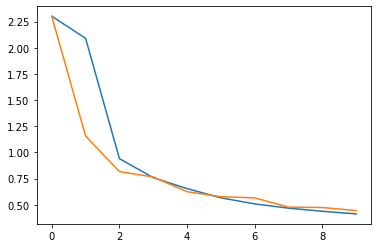

In [ ]:
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), test_losses)

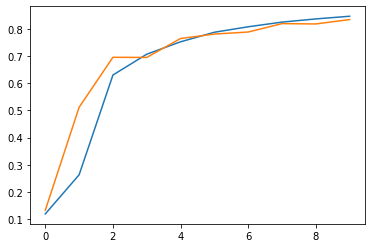

In [ ]:
plt.plot(range(epochs), train_accs)
plt.plot(range(epochs), test_accs)